
# Winter school - IMB

## scRNA-seq


In this practical module, we will get familiar with single cell sequencing (scRNA-seq) gene expression data. We will go through several main analysis types, including preprocessing, clustering, and cell type annotation. Some parts in this section were inspired from the scanpy workflow by Fabian Theis's Group (see [Wolf *et al*. SCANPY: large-scale single-cell gene expression data analysis. *Genome Biol* 19, 15 (2018)](https://doi.org/10.1186/s13059-017-1382-0)). 

### Resources

* The UQ Bioinformatics Python Guide (on Blackboard)
* The [Python 3 documentation]. For those unfamiliar with Python the [official tutorial] is recommended
* The Software Carpentry [novice Python lessons]
* [IPython's own notebook tutorial](http://nbviewer.jupyter.org/github/ipython/ipython/blob/3.x/examples/Notebook/Index.ipynb)
* [Markdown cheatsheet] (Markdown is the syntax you use to write formatted text into cells in a notebook.)

[Python 3 documentation]: https://docs.python.org/3/
[official tutorial]: https://docs.python.org/3/tutorial/index.html
[novice python lessons]: http://swcarpentry.github.io/python-novice-inflammation/
[Markdown cheatsheet]: https://github.com/adam-p/markdown-here/wiki/Markdown-Here-Cheatsheet

Often, there is a need to have a common analysis framework that allows the broad research community to use as a starting point for the analysis to establish baseline results that can be comparable across research groups, projects and technologies. Scanpy (Python) and Seurat (R) are such frameworks for single cell analysis. Imporantly, it is necessary to understand the background theory and the low-level codes behind convenient wrapper functions.

For scRNA-seq data, over 30 analysis types and more than 700 software programs are available. These programs are written in different languages, most commonly in R and Python. For updated information about the scRNA-seq analysis software collection, refer to scRNAtool website, https://www.scrna-tools.org/. 

#  Part 1: Understanding single cell data, preprocessing and clustering

## 1. Setting up 
### 1.1 Annotated data object 


Single cell data has multiple layers of information, not just the large gene expression matrix. Often, the expression matrix is ~1000 times larger than a traditional RNA-seq dataset. Additional layers, for example, include information about the cell type of each cell, the sequencing experiment condition (batch), genes and gene groups, and various dimensionality reduction matrices, or even images of the tissues where the single cells were extracted. To handle all information in one Python object, the Theis's Lab has developed Anndata object structure, with the aim to provide a common framework for various Python-based software to work with single cell data.

<p align="center">
<img src="https://falexwolf.de/img/scanpy/anndata.svg" alt="" width="500" height="338" />
</p>


The diagram above describes the structure of an AnnData object. AnnData stores four main slots (layers): 1) a gene expression matrix .X, 2) annotations of cells .obs, 3) annotation of genes .var,  and 4) unstructured annotations .uns. Each component has one or several datatypes. You may notice the gene expression dataset has sparse matrix format, which is especially suitable for single cell gene expression data, because there are many 0 values in the dataset. Additional/customised layers can be added to the AnnData object.

## 2. The PBMC dataset 

To get a good feel of scRNAseq data and key analysis types, we will use a 'small' dataset with 2,700 Peripheral Blood Mononuclear Cells (PBMC). The PBMC dataset has well-characterised immune cell types. This dataset has been used by researchers around the world as one of the gold-standard dataset for the development and comparison of new analysis methods. 

We have provided this data already, in the directory where this ipython notebook is located in the 'data/' folder. 
How we downloaded this data is provided below.

If you are interested in exploring a similar, but larger dataset, you can try downloading the PBMC 68,000 cells at https://cf.10xgenomics.com/samples/cell-exp/1.1.0/fresh_68k_pbmc_donor_a/fresh_68k_pbmc_donor_a_filtered_gene_bc_matrices.tar.gz. With this larger dataset, you will need a large RAM and some steps (e.g. PCA) will take longer to run. 

In [1]:
#manually download the PBMC dataset (7.3 MB)
#!mkdir data
#!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
#!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
#!mkdir write

In [3]:
# Setting up python environment #
import numpy as np
import pandas as pd
import scanpy as sc
from scipy import sparse, stats
import anndata as anndata
from sklearn.utils import sparsefuncs, issparse
import seaborn as sbn
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from sklearn.cluster import AgglomerativeClustering
from pathlib import Path
#! pip install scvi-tools # optional for variational autoencoder exercise 
# import scvi # optional for variational autoencoder exercise 

In [4]:
# Suppress warnings for tidy representation of the notebook   
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    
def print_msg(msg_lst: list, sep='\t', color='\033[91m'):
    msg = ""
    for i in msg_lst:
        msg += str(i) + sep

    print(color + "-" * 80 + bcolors.ENDC)
    print(color + msg.center(80, ' ') + bcolors.ENDC)
    print(color + '-' * 80 + bcolors.ENDC)

### 2.1 Load the data 
- There are multiple ways to load single cell data. Typically, a single cell dataset after mapping reads to the genome will contain three main components:  barcodes.tsv (cell IDs), genes.tsv, matrix.mtx (expression matrix).

- We will load the data in the typical way for scRNA-seq data from the 10X platform, as is usually outputted by the 'CellRanger' software. 

In [5]:
#############################
#   Loading the Data   # 
#############################

pbmc = sc.read_10x_mtx(
    '/data/module5/Datasets/scRNAseq_10xPBMC/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading
pbmc

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

#### The Nature of the Data

- Single cell RNA-seq is plagued with a large source of technical variation - an extremely low sampling of the total number of mRNAs captured by the cell. The result of this is that there are few genes captured per cell; and typically few reads per gene. This results in what is referred to as a 'sparse matrix'; whereby the majority of values within the matrix are '0'. 

- Below, we illustrate this by visualising this matrix; rows are genes, columns are cells.

<span style="color:blue">**Example: plot a graph to visualise the sparsity of the pbmc single cell gene expression matrix**</span>

--------------------------------------------------------------------------------
                   This is an example answer to the question	                   
--------------------------------------------------------------------------------


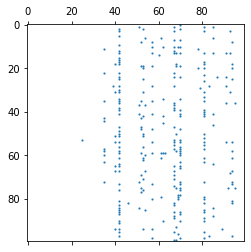

In [6]:
print_msg(['This is an example answer to the question'], color=bcolors.OKBLUE)
# Visualise the sparse matrix as an image 
plt.spy(pbmc.X[:100,:100],  markersize = 1)

Looking at the map above of genes with 0 expression values (white space) compared to non-zero values (blue dots), you would appreciate the sparsity of the data.

<font color='red'> **Example: What is the percent of zero values in this dataset (accurate to 2 decimal places)? How many genes were universally expressed in all cells? <font> (1 mark)

In [8]:

n_cells_detected = pbmc.X.getnnz(axis=0)
pct_non_zero = n_cells_detected.sum()/(pbmc.X.shape[0]*pbmc.X.shape[1])*100
print("percent of zero values is ", round(100 - pct_non_zero,2), "%")
print("Number of genes universally expressed in all cells is ",sum(n_cells_detected == pbmc.X.shape[0]))
# The only gene that was found in all cells 
print("And that only  gene is", pbmc.var_names[sum(n_cells_detected == pbmc.X.shape[0])])

percent of zero values is  97.41 %
Number of genes universally expressed in all cells is  1
And that only  gene is FAM138A


## 3 Exploratory data analysis (Quality control)

- Before doing any in-depth analysis to reach a biologically meaningful conclusion, it is essential to examine the data and remove low quality (outlier) cells and genes. We will go through the typical quality control (QC) analysis steps. We will remove cells with few genes and total detected reads, and also genes which are detected very rarely and at low abundance.

- It is also usual to remove cells that may have been damaged during tissue preparation; these are typically demarcated by unusually high levels of mitochondrial and ribosomal gene expression. 

### 3.1 QC statistics at cell levels

- In an scRNAseq experiment, each cell is compartmentalised into a separate oil droplet, and sequencing preparations occur in each droplet. Therefore, technical variation exists between cells. For example, some cells appear to have more reads that are mapped to mitochondrial genes (likely due to cells were stressed due to experimental handlings) or ribosomal genes (partly dueto failure to capture other genes within the cells). Another example is that some cells have more sequencing reads or more genes detected than in the other cells. 

<span style="color:blue">**Example: find how many mitochondrial and ribosomal genes in the dataset? Hints: look for gene symbols starting with 'MT-', 'RPL', 'RPS'**</span>

In [9]:
print_msg(['This is an example answer to the question'], color=bcolors.OKBLUE)
# Number of mitochondrial genes
print("Total Mt genes ", sum(pbmc.var_names.str.startswith('MT-')))
# Number of ribosomal genes
print("Total Rb genes ", sum(pbmc.var_names.str.startswith(('RPL', 'RPS'))))

--------------------------------------------------------------------------------
                   This is an example answer to the question	                   
--------------------------------------------------------------------------------
Total Mt genes  13
Total Rb genes  106


<font color='red'> **Assignment question A2**: Find Pearson correlation between the total reads per cell and total genes detected per cell (accurate to 2 decimal places). (1 mark) <font>

In [10]:
pbmc.X.sum(axis=1)

matrix([[2421.],
        [4903.],
        [3149.],
        ...,
        [1684.],
        [1024.],
        [1985.]], dtype=float32)

<font color='purple'> **Example**: Generate a plot to assess the variation in the total reads per cell and total genes detected per cells across the 2700 cells. <font>

- <u> *Discussion:* </u> Why is there a positive correlation? Should this dataset be sequenced more to detect more genes (when the increase gets saturated)?

The answer is  0.95


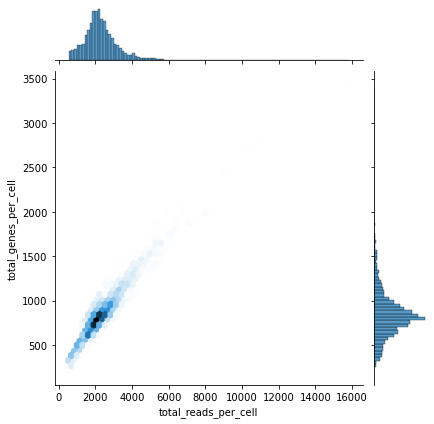

In [11]:
# Find the number of detected genes per cell 
obs_metrics = pd.DataFrame(index=pbmc.obs_names)
obs_metrics["total_genes_per_cell"] = pbmc.X.getnnz(axis=1)
obs_metrics["total_reads_per_cell"] = pd.DataFrame(pbmc.X.sum(axis=1)).iloc[:,0].values
pbmc.obs = obs_metrics
# Or a combined plot  
sbn.jointplot(data=pbmc.obs, x="total_reads_per_cell", y="total_genes_per_cell", kind="hex")

# Correlation 
corr = np.corrcoef(obs_metrics["total_genes_per_cell"], obs_metrics["total_reads_per_cell"])
print("The answer is ", round(corr[1,0],2))

<font color='red'> **Example**: Find Pearson correlation between total reads mapped to ribosomal genes per cell and total reads (i.e. reads across all genes) per cell (accurate to 2 decimal places). </font>

<font color='purple'> **Example**: Generate a scatter plot of total reads mapped to ribosomal genes per cell and total genes per cell. Why cells with too many ribosomal reads can bias the comparison of all genes in a transcriptome? Hints: can start with the script below <font>

In [12]:
# QC statistics for some key genes 

from scipy.stats import pearsonr

pbmc.var['mt'] = pbmc.var_names.str.startswith('MT-') #Mitochondrial genes 
pbmc.var['rb'] = pbmc.var_names.str.startswith(('RPL','RPS')) #Ribosomal genes

# Find mitochondrial genes:
mt_reads = pd.DataFrame(pbmc.X[:, pbmc.var['mt'].values].sum(axis=1)).values
mt_reads = mt_reads.flatten()
pbmc.obs['mt_reads'] = mt_reads

# Find ribosomal gene reads
rb_reads = pd.DataFrame(pbmc.X[:, pbmc.var['rb'].values].sum(axis=1)).values
rb_reads = rb_reads.flatten()
pbmc.obs['rb_reads'] = rb_reads

print("The MT correlation is \n", round(np.corrcoef(pbmc.obs["total_reads_per_cell"],
                                           pbmc.obs["mt_reads"])[1,0], 2)
     )
print("The RB correlation is \n", round(np.corrcoef(pbmc.obs["total_reads_per_cell"],
                                           pbmc.obs["rb_reads"])[1,0], 2)
     )
# Check it is the same with 
print(pearsonr(pbmc.obs["total_reads_per_cell"], pbmc.obs["mt_reads"]))


The MT correlation is 
 0.71
The RB correlation is 
 0.76
(0.7107974292889144, 0.0)


<font color='red'> **Example**: How many cells have more than 5% mitochondrial reads, (1 mark)? How many cells have more than 50% ribosomal reads, (1 mark)?  </font>

In [13]:
##########
# Answer #
##########

# QC statistics for some key genes 
total_reads_per_cell = pbmc.obs['total_reads_per_cell'].values

# Find mitochondrial genes:
total_reads_per_cell_nz = total_reads_per_cell[total_reads_per_cell > 0]
mt_reads_nz = mt_reads[total_reads_per_cell > 0]
pct_mt_reads = mt_reads_nz/total_reads_per_cell_nz
print('number of cells with more than 5% mitochondrial reads is', len(pct_mt_reads[pct_mt_reads>0.05]))

# For ribosomal genes 
rb_reads_nz = rb_reads[total_reads_per_cell > 0]
pct_rb_reads = rb_reads_nz/total_reads_per_cell_nz
print('number of cells with more than 50% ribosomal reads is', len(pct_rb_reads[pct_rb_reads > 0.50]))



number of cells with more than 5% mitochondrial reads is 57
number of cells with more than 50% ribosomal reads is 87


<font color='purple'> **Example**: Compare cells containing >20% mitochondrial reads with the remaining cells (likely healthy cells)? Comment about whether these cells have signs of technical biases (e.g. expressing more stress response genes)? <font>

### 3.2 QC at genes level 

- In an scRNAseq experiment, lowly expressing genes can be misdetected (i.e. genes are expressed in the cells but have value as 0 in the gene expression matrix). These genes add noise to many downstream analysis types. Therefore, it is better to remove these genes. 

- So far we have looked at QC metrics for cells. Next we will examine metrics for genes. 

<font color='Red'> **Example**: How many percent of reads mapped to the top 100 genes with most reads?  (1 mark).  </font>  

Here we are asking you to first identify the 100 genes with the most reads mapping to them across all cells. Then we want you to calculate what is the percentage of reads that map to these genes compared to all genes.

In [14]:
total_reads_per_genes = np.array(pbmc.X.sum(axis=0)).flatten()

gene_metrics = pd.DataFrame(index=pbmc.var_names)
gene_metrics["total_reads_per_genes"] = total_reads_per_genes
top100 = gene_metrics.sort_values("total_reads_per_genes", ascending=False)["total_reads_per_genes"][:100]
pct_top100 = sum(top100)/sum(gene_metrics["total_reads_per_genes"])*100
print("Percent of reads mapped to top 100 genes ", round(pct_top100,2))

Percent of reads mapped to top 100 genes  51.27


In [15]:
top100

MALAT1    161685.0
TMSB4X    124210.0
B2M       121363.0
RPL10      88517.0
RPL13      77111.0
            ...   
HLA-B      13247.0
OAZ1       13238.0
EEF1D      13130.0
RPS24      13056.0
MT-ND1     13011.0
Name: total_reads_per_genes, Length: 100, dtype: float32

<font color='Red'> **Example**: Using gprofiler (or scanpy wrapper of gprofiler), find the most enriched ontology group these top genes represent. (1 mark)<font>  
    
How many of the top 10 most significant GOs are related to translation and ribosomal processes?
    
Hint: you'll probably need to check out the `scanpy` and `gprofiler` documentation for this one!

In [16]:
#! pip install gprofiler-official
from gprofiler import GProfiler
# n = []
# for i in hundred_most.index:
#     n.append(i)

print('The following data frame shows the enriched top 100 abundant genes list. This enrichment was conducted using gprofiler:')

#Enriching for top 100 genes using scanpy and gprofiler
go_results = sc.queries.enrich(top100.index.values.tolist(), org="hsapiens")#organism is homosapiens
print(go_results.iloc[0:10,:])#Getting top 10 rows
print("The answer is", 10)


The following data frame shows the enriched top 100 abundant genes list. This enrichment was conducted using gprofiler:
  source              native  \
0  GO:CC          GO:0022626   
1   REAC   REAC:R-HSA-156842   
2   REAC   REAC:R-HSA-156902   
3   REAC   REAC:R-HSA-192823   
4   REAC    REAC:R-HSA-72764   
5   REAC  REAC:R-HSA-2408557   
6   REAC   REAC:R-HSA-975956   
7   REAC    REAC:R-HSA-72689   
8   REAC  REAC:R-HSA-9633012   
9  GO:BP          GO:0002181   

                                                name        p_value  \
0                                 cytosolic ribosome  5.211310e-144   
1                  Eukaryotic Translation Elongation  1.053886e-137   
2                           Peptide chain elongation  5.977321e-137   
3                             Viral mRNA Translation  8.687820e-134   
4                 Eukaryotic Translation Termination  1.757143e-131   
5                           Selenocysteine synthesis  1.757143e-131   
6  Nonsense Mediated Decay (NM

<font color='purple'> **Example**: Are these genes informative about gene regulation processes (e.g. when comparing diseased vs healthy conditions)? <font>

### 3.3 Removing cell and gene outliers 

- So far we have assessed the possible noisy data coming from cells and genes due to experimental constraints. Next, we will look at how to remove the noise. 

#### Removing poor quality cells 

In [14]:
###################
# example NOT run #
###################

#sc.pp.filter_cells(pbmc, min_genes=200)
#pbmc = pbmc[pbmc.obs.n_genes_by_counts < 2500, :]
#pbmc = pbmc[pbmc.obs.pct_counts_mt < 5, :]


- <u> *Discussion:* </u> A traditional way to filter cells using a 'hard' thresholds is to remove cells with too many genes (e.g. more than 2500 genes, or has more than 5% of mitochondrial reads).  A better way to remove outlier cells is to use dataset-dependent distribution to define thresholds that are less/not dependent on outlier values.

- Here we use median absolute deviation (MAD), calculated by the following formula: MAD = median(| x - median(x)|) 
- If we use +- 3*MAD as a range to define lower and upper bounds (values adaptively change between datasets), we can consistently remove outliers. 
- We can apply the method above using MAD of total genes per cell for filtering. Cells with fewer than the lower bound have low transcriptome diversity, while cells with more than the upper bound genes may be considered over abundant in the number of genes detected. 

<font color='red'> **Example**: Assuming potential outlier cells are those outside the median +- 3xMAD genes per cell range. How many cells are potential outlier cells? (1 mark) </font> 

Note we expect you to use: `>` and `<` i.e. not `>=` or `<=`

Tip: You need to caculate the MAD (Mean absolute deviation) for the `number of genes` per cell (the scipy stats package might help with this!) and then find the cells that are outside the +- 3xMAD range.

<font color='purple'> **Example**: Compare outlier cells with the remaing cells by using metrics like mitochondial and ribosomal reads, top abundant genes, and/or differentially expressed genes. Do you think these potential outlier cells should be removed and why? <font>

In [17]:
##############
#   Answer   #
##############

total_genes_per_cell = pbmc.obs['total_genes_per_cell']
threeMAD_total_genes = 3 * stats.median_abs_deviation(total_genes_per_cell)
lower_bound = np.median(total_genes_per_cell) - threeMAD_total_genes
upper_bound = np.median(total_genes_per_cell) + threeMAD_total_genes

# Number of outlier cells
counter = 0
for ttg in total_genes_per_cell:
    if ttg < lower_bound or ttg > upper_bound: 
        counter += 1  
print("The number of outlier cells is: ", counter) 


The number of outlier cells is:  353


Number of cells after filtering cells:  2347


<AxesSubplot:xlabel='total_genes_per_cell', ylabel='Density'>

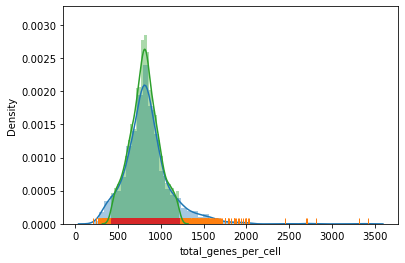

In [18]:
###################
# example NOT run #
###################

# Before filtering cells 
sbn.distplot(pbmc.obs.total_genes_per_cell)
sbn.rugplot(pbmc.obs.total_genes_per_cell)
# After filtering cells 
pbmc_filtered = pbmc[pbmc.obs.total_genes_per_cell > lower_bound, :]
pbmc_filtered = pbmc_filtered[pbmc_filtered.obs.total_genes_per_cell < upper_bound, :]
print('Number of cells after filtering cells: ', pbmc_filtered.shape[0])
# Check the effect of data preprocessing, notice the change to the normal distribution 
sbn.distplot(pbmc_filtered.obs.total_genes_per_cell)
sbn.rugplot(pbmc_filtered.obs.total_genes_per_cell)

#### Removing unreliably detected genes

- Many of the 32,738 genes have 0 expression values in all cells. These genes can be removed from downstream analysis.
- Further, genes that only found in one cell would likely be technical noise or transcriptional randomness. Analysis of these genes will not yield significant results. 
- For some cases, the lower bound calculated by the 3MAD formula is less than 0, so there is no point using it as a cutoff. We reasoned that for a gene to be reliably detected, it needs to be detected in at least three cells (or as a minimum, in two cells), so we use a 'hard' cutoff of 3 cells in this case. 
- We can see that the number of reliably detected genes was much lower than the total number of genes that could possibly be mapped. This observation is reaseanable, given that only a subset of all genes are active in any certain cell types. Removing noisy genes makes the analysis faster and more accurate (e.g. when scaling the whole dataset, noisy genes will get the same weight as informative genes).

## 4 Normalisation (between cells) 

- In this dataset, there is one sample (one experimental condition/replicate), so we won't go through between sample normalisation. However, we will still need to perform between cell normalisation. 
- In scRNA-seq data, sequencing data for each cell is separate from other cells (e.g. each cell is compartmentalised into one oil droplet, and reactions happen within each oild droplet), therefore technical variation happens between cells.
- We will scale the original data so that each cell will have 10,000 reads, maintaining the distribution of gene abundance within each cell, globally scaling genes up or down. Global scaling is a fast and simple way for cell-to-cell normalisation. However, more accurate normalisation methods are available and will be discussed in the lecture, but will not be tested here due to the long running time and large computer memory required. For example, scran and scTransform are two better methods compared to global scaling

### 4.1 Normalisation to a constant library size 

In [20]:
X = pbmc.X.copy()
reads_per_cells = pbmc.obs['total_reads_per_cell'].values
# set the total number of reads after scaling normalisation as 1e4 (i.e. assuming every cell has the same number of reads mapped to the cells as 1e4 reads)
after = 1e4 
counts = np.asarray(reads_per_cells)
scale_factors = counts / after   # scale factor for each cell 
if issparse(X):
    sparsefuncs.inplace_row_scale(X, 1/scale_factors)
else:
    np.divide(X, counts[:, None], out=X)
reads_per_cells_norm = X.sum(axis=1)
stats.describe(reads_per_cells_norm) # confirm that most cells have total reads ~1e4

DescribeResult(nobs=2700, minmax=(array([9999.998], dtype=float32), array([10000.002], dtype=float32)), mean=array([10000.], dtype=float32), variance=array([5.4874255e-07], dtype=float32), skewness=array([0.], dtype=float32), kurtosis=array([-3.], dtype=float32))

### 4.2 Normalisation by median 

- Section 4.1 above shows how one can normalise the dataset so that each cell has 10,000 reads per cell after normalisation. This approach is common, but is not always ideal because there are cases that some datasets have deeper sequencing and thus most cells may have more than 10,000 reads. In these cases, setting every cell to have 10,000 reads will lead to information loss.

<font color='red'> **Example**: Normalise by adusjusting the total reads per cell to a median value between all cells. How many cells have scale factors greater than 1? (1 mark) </font> 

In [21]:
counts

array([2421., 4903., 3149., ..., 1684., 1024., 1985.], dtype=float32)

In [22]:
##############
#   Answer   #
##############
X = pbmc.X.copy()
reads_per_cells = pbmc.obs['total_reads_per_cell'].values
counts = np.asarray(reads_per_cells)
after = np.median(counts, axis=0)  # if after is not provided, normalise everything to the median count
scale_factors = counts / after 
print("Number of cells with scale factor >1 ", len(scale_factors[scale_factors > 1.0]))
if issparse(X):
    sparsefuncs.inplace_row_scale(X, 1/scale_factors)
else:
    np.divide(X, counts[:, None], out=X)

Number of cells with scale factor >1  1349


### 4.3 Assess normalisation effects 

- Save raw data, before replaced by normalised data. Set the .raw attribute of AnnData object to freeze the state of the AnnData object. You can get back an AnnData of the object in .raw by calling .raw.to_adata()
- <u> In section 7, we are introducing an advanced probabilistic normalisation method using Variational Autoencoder </u>. This section is optional but will most likely very fun for evrybody to give a try 


In [23]:
# Use a AnnData function 
pbmc.raw = pbmc
# Write the normalised matrix to pbmc object 
pbmc.X = X

Text(0.5, 1.0, 'Before normalisation')

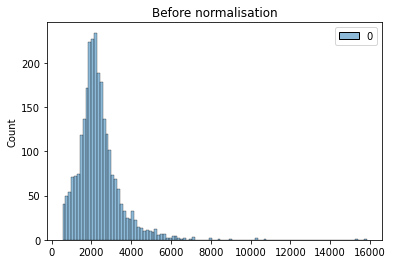

In [24]:
# You can restore the value before normalisation 
sbn.histplot(pbmc.raw.X.sum(axis=1))
plt.title('Before normalisation')

Text(0.5, 0.98, 'ACTB expression')

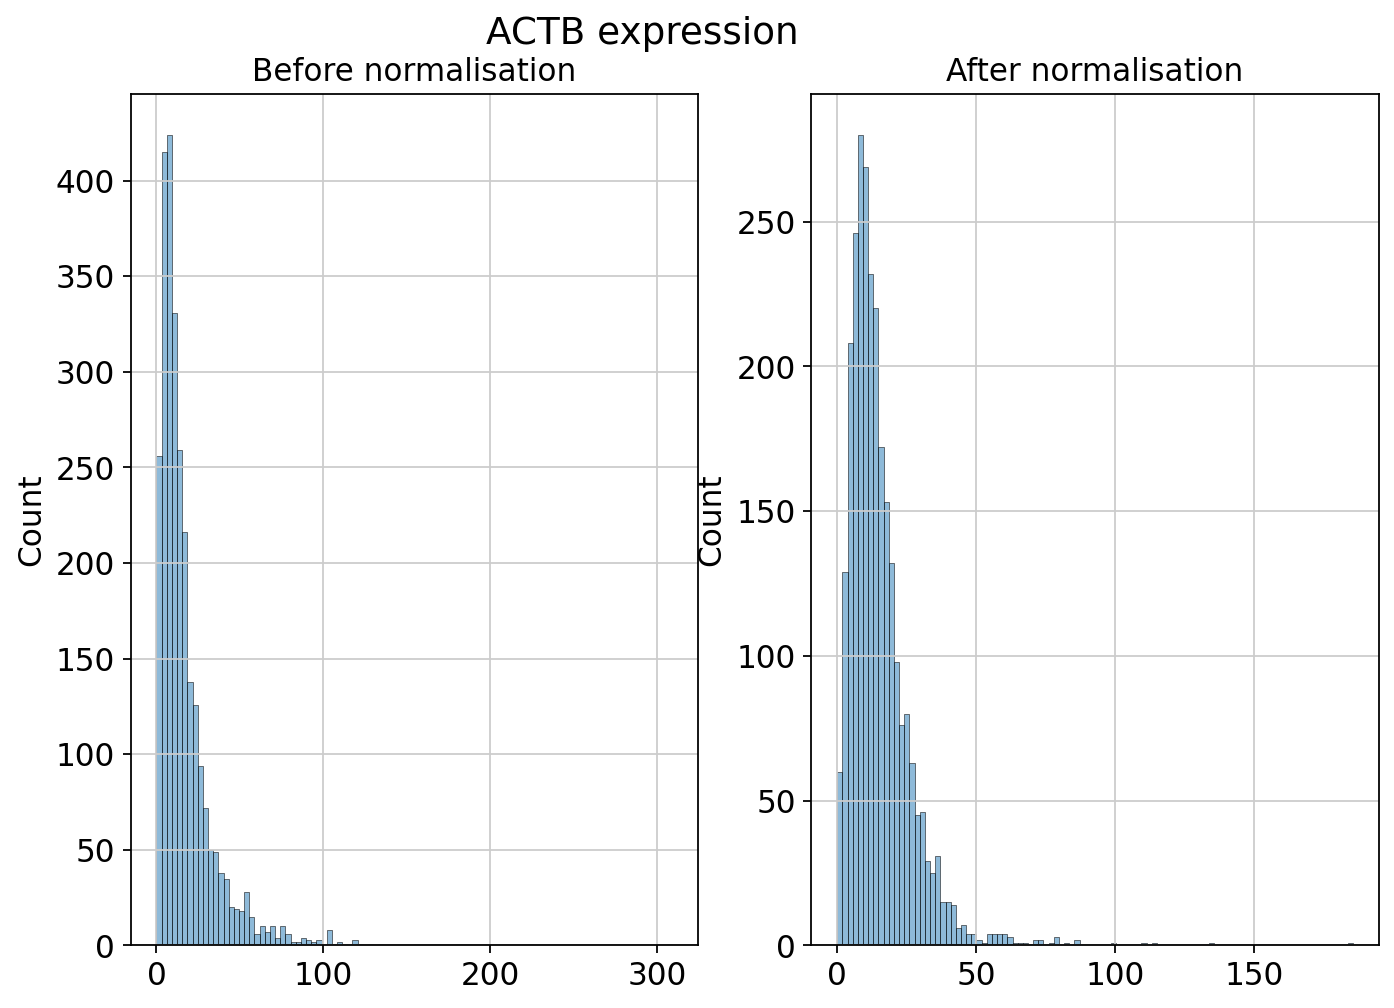

In [25]:
# Comparing gene distribution before and after normalization
sc.set_figure_params(figsize=(10, 7))

fig, (ax1, ax2) = plt.subplots(1,2)
gene='ACTB' # change gene name to see several genes 
gene_expr = pbmc.raw.X[:,pbmc.raw.var.index == gene].todense()
sbn.histplot(gene_expr, 
             legend=False, bins =100, ax = ax1)
ax1.set_title('Before normalisation')

gene_expr_after = pbmc.X[:,pbmc.var.index == gene].todense()
sbn.histplot(gene_expr_after, 
             legend=False, bins = 100,  ax = ax2)
ax2.set_title('After normalisation')

fig.suptitle(gene + ' expression')

Text(0.5, 0.98, 'GAPDH expression')

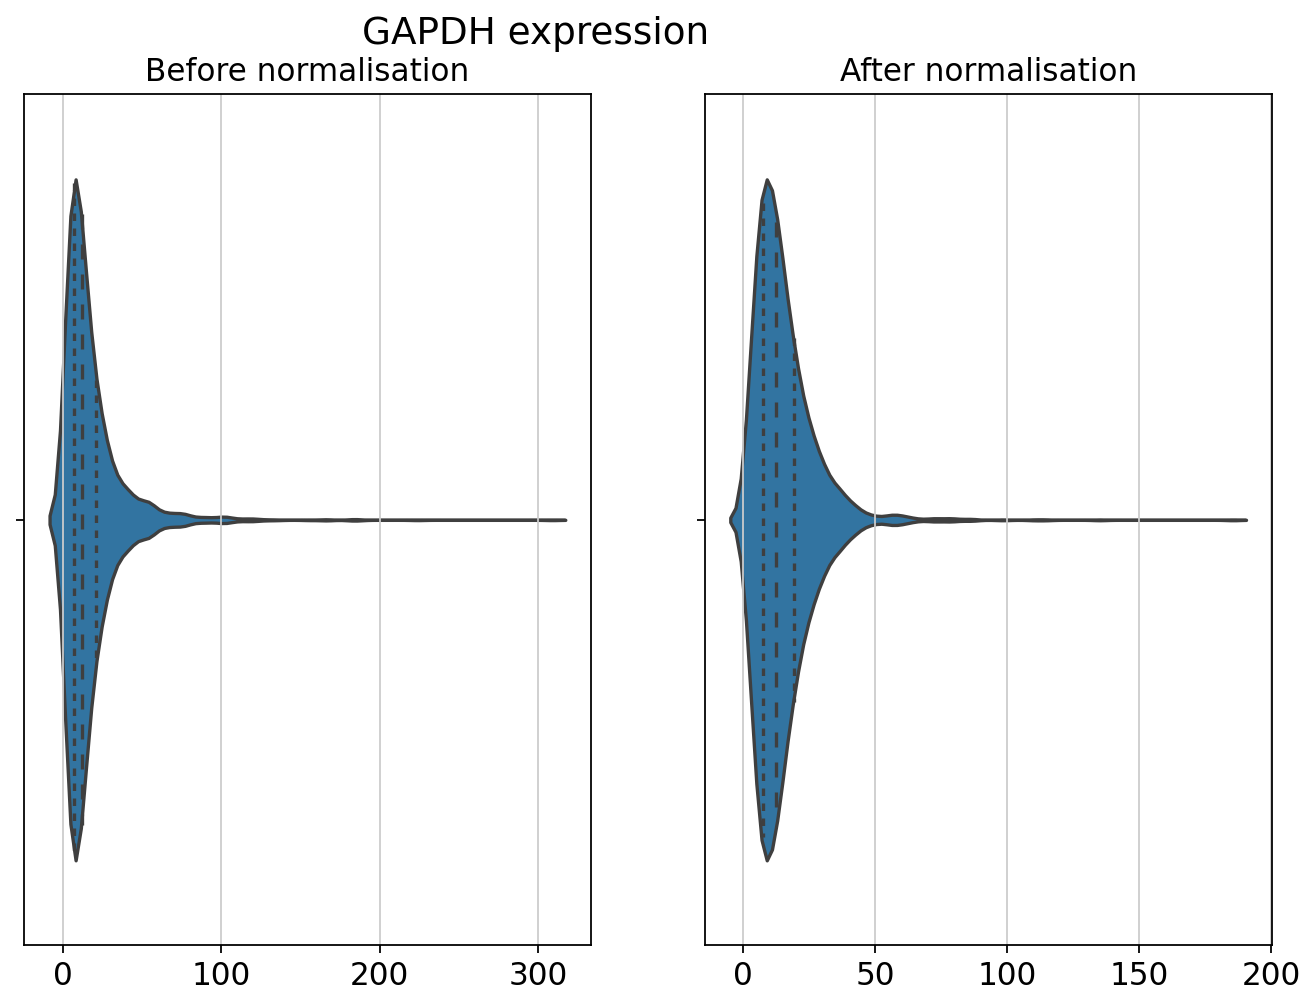

In [26]:
# comparing gene distribution before and after normalization
fig, (ax1, ax2) = plt.subplots(1,2)
sbn.violinplot(gene_expr, 
             legend=False,  inner="quartile",ax = ax1)
ax1.set_title('Before normalisation')

sbn.violinplot(gene_expr_after, 
             legend=False, inner="quartile",  ax = ax2)
ax2.set_title('After normalisation')

fig.suptitle('GAPDH expression')

## 5 Dimensionality reduction 

- Dimension reduction seeks to produce a low dimensional representation of high dimensional data that preserves relevant structure. Dimension reduction is needed in single cell data analysis for representation, noise reduction, faster computation and contributing to solving the “curse of dimensionality”. 

- The “curse of dimensionality” refers to the fact that the number of observations (n) needed to estimate parameters (e.g. classification parameters in a logistic classifier for single cells) increases rapidly when the number of input variables (e.g. p genes or p dimensions) increases.

- scRNA-seq data with many genes and so many cells can have a lot of technical noise (e.g. very few copies of a gene in a cell may be missed by PCR reaction during single cell sequencing).  

- By analysis such as the Principal Component Analysis (PCA), each principal comnponent can be thought of as a 'metagene' or a latent (unseen, unknown) 'metafeature' that combines information across a correlated gene set or experimental/biological conditions. 

- The use of the top principal components that explain most variation in the dataset can be considered as a way to compress/represent/simplify the dataset without loosing much information (i.e. preserving the data structure). 

### 5.1 Linear dimensionality reduction 

- PCA applies orthogonal transformation to the initial Euclidean distance matrix derived from the full expression matrix containing all genes. The method creates low-dimensional embeddings that best preserves the overall variance of the dataset.

- Before PCA, we will scale the data (also called standardization), so that the data structure won't be affected by just abundant genes. After scaling, each gene will have expression value with standard deviation equal 1 (by dividing each gene expression value for a cell by the standard deviation of that genes across all cells in a sample) and mean equal 0 (substract each gene expression value by the sample mean). It is important to think about how this scaling step can affect the weighting/importance of lowerly expressed genes.


In [27]:
# The scaled data is then used for PCA analysis
sc.pp.scale(pbmc)
sc.tl.pca(pbmc, svd_solver='arpack')

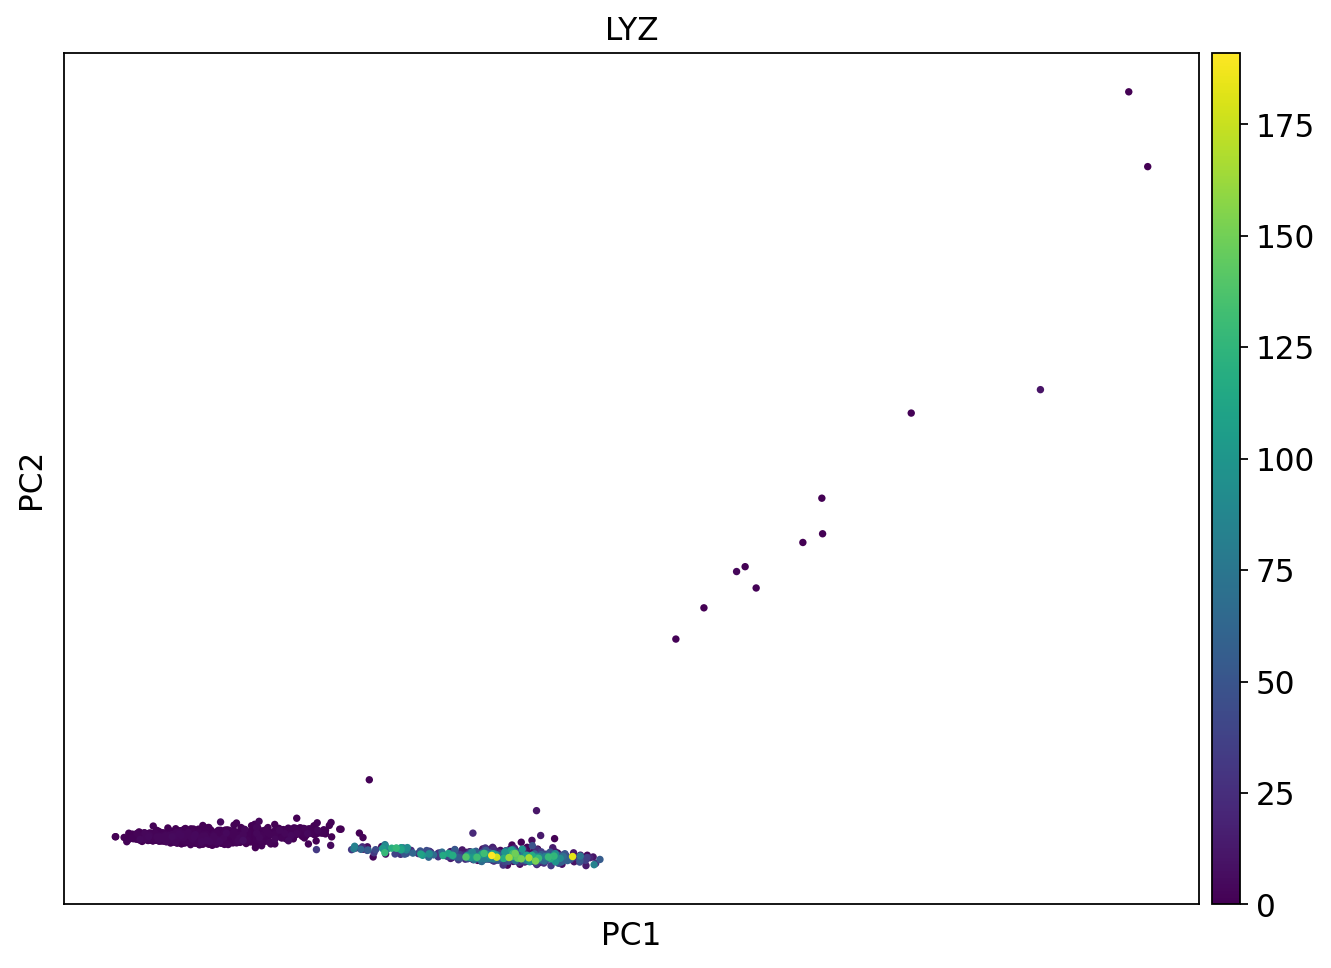

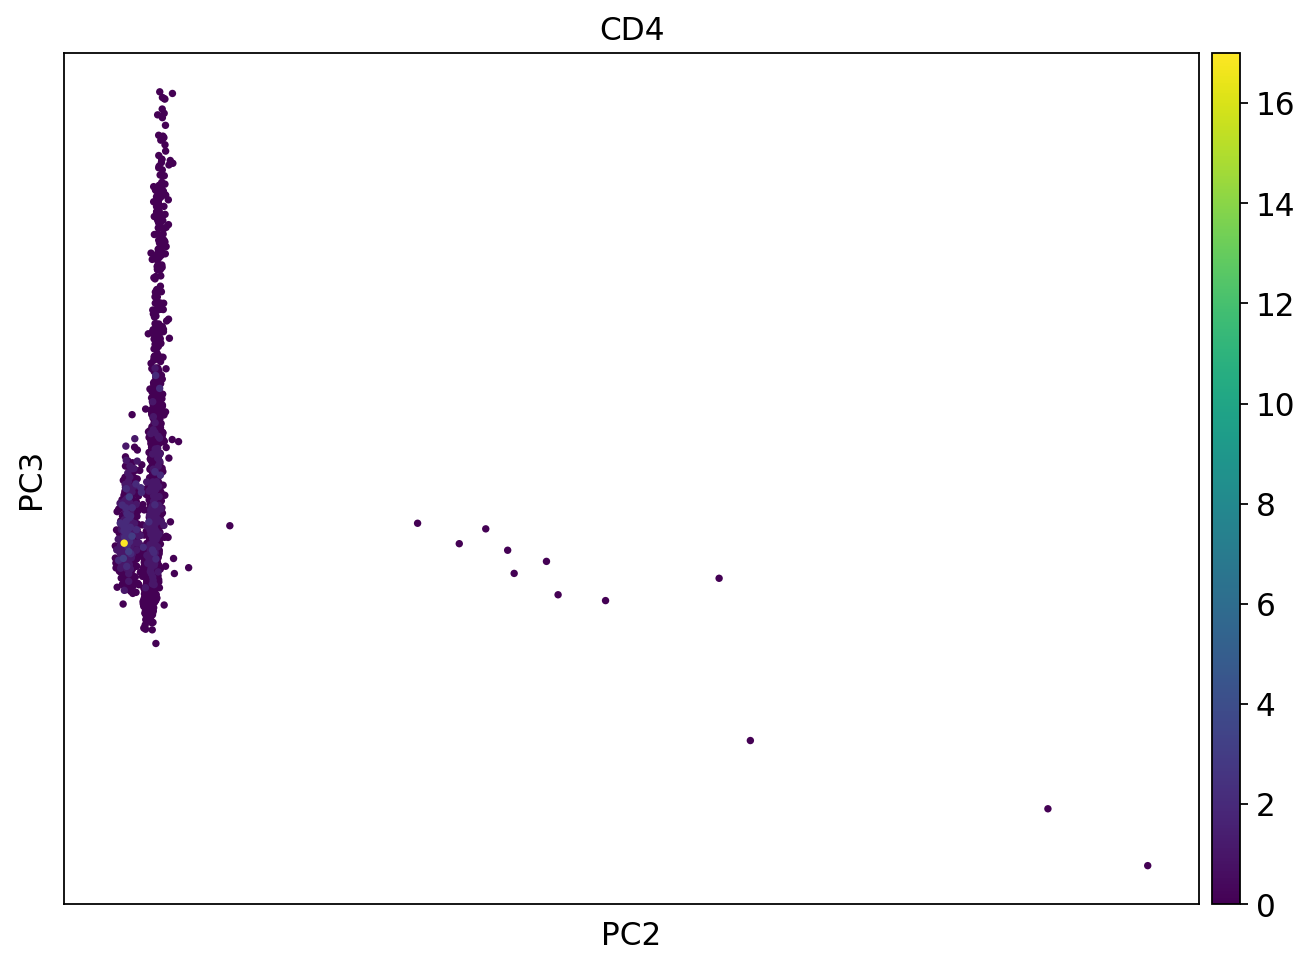

In [28]:
sc.pl.pca(pbmc, color='LYZ')
sc.pl.pca(pbmc, color='CD4',components= [2,3])

<font color='red'> **Example**: What is the percent of the variance in the dataset that the first 500 PCs can explain (accurate to 2 decimal places), (1 mark)? Note: scaling the data across genes to unit variance and 0 mean is needed (it is interesting to think about the need to do this for gene expression data) </font>

In [29]:
##############
#   Answer   #
##############

from sklearn.decomposition import PCA
pca = PCA()
pca.fit(pbmc.X)
print("Percent variance explained by the first 500 PCs ",round(np.sum((pca.explained_variance_ratio_)[0:500])*100, 2), "%")


Percent variance explained by the first 500 PCs  34.95 %


<font color='purple'> **Example**: How is this percent of variance explained in PCA analysis of scRNA-seq data different to a typical PCA analysis for a standard RNA-seq dataset? <font>

### 5.2 Nonlinear dimensionality reduction 
- Nonlinear dimensionality reduction techniques take a set of points in a high-dimensional space and find a representation of those points in a lower-dimensional space, typically a 2-to-3 dimensional plane, in such a way that local and global structure of the data are preserved as much as possible. Nonlinear techniques are able to avoid overcrowding of the representation, i.e. they can separate cell populations in a 2-to-3 dimensional space.

In [30]:
# Find neighbor in PCA space, estimating connectivities of data points
# You may want to change n_neighbors and see how does it affect the results in local and global view of the UMAP plots
    
sc.pp.neighbors(pbmc, n_neighbors=10, n_pcs=40)

/software/anaconda3/envs/module5/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Use Uniform Manifold Approximation and Projection (UMAP) 

In [27]:
# Embedding the neighborhood graph
sc.tl.umap(pbmc)

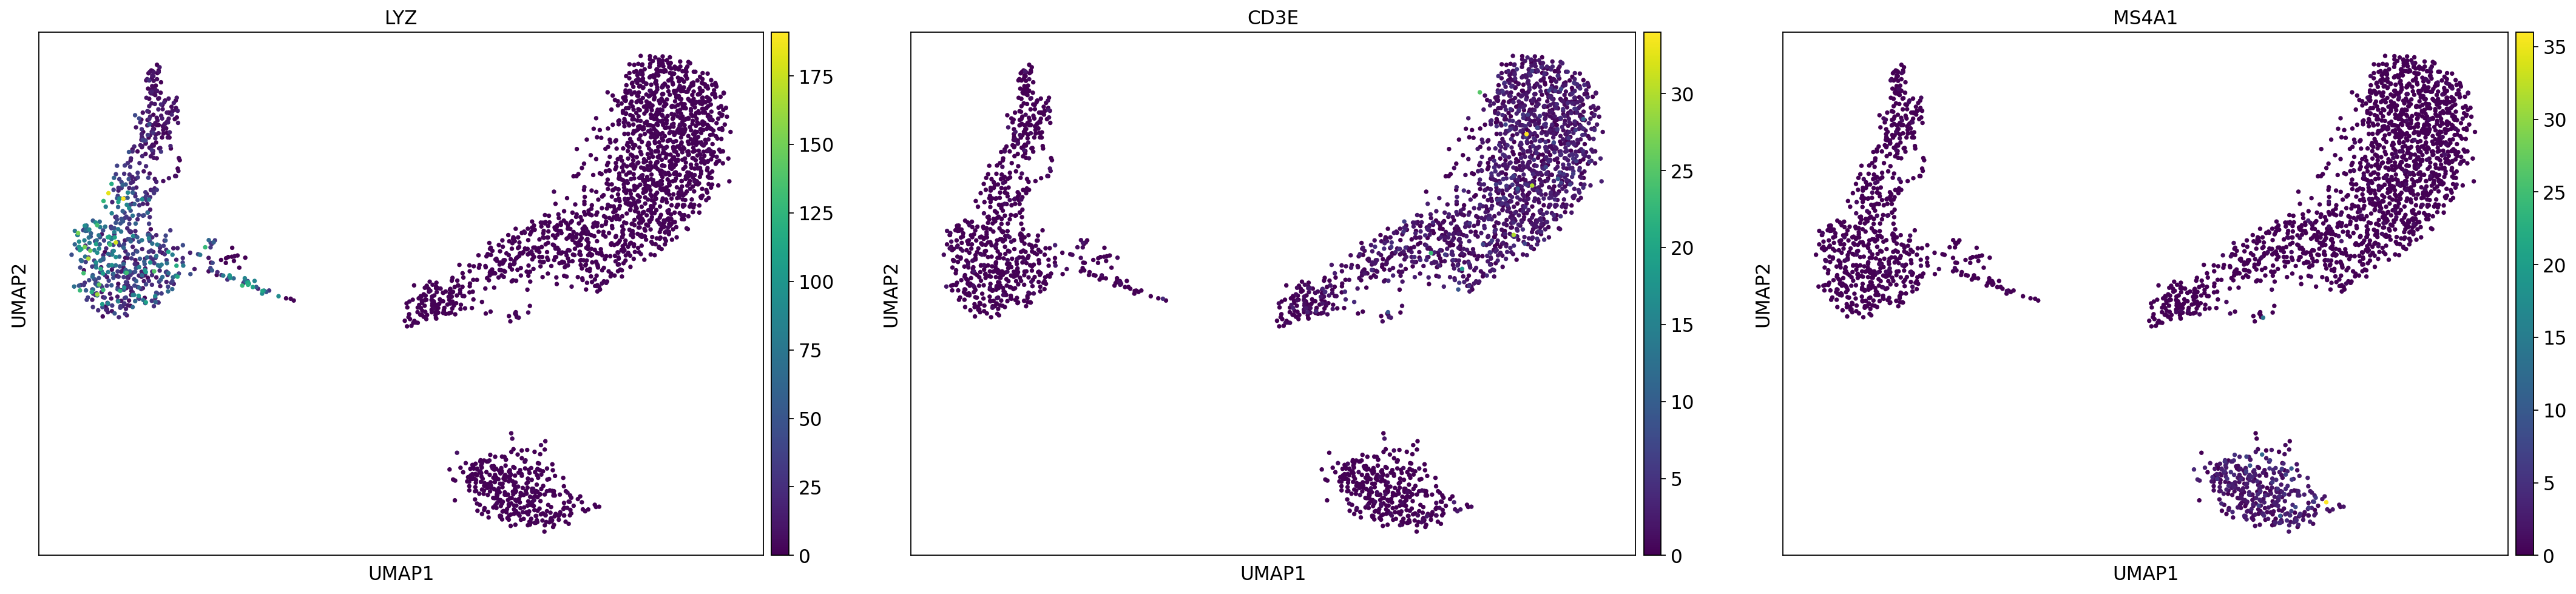

In [28]:
# n_neighbors = 10
sc.pl.umap(pbmc, color=['LYZ','CD3E','MS4A1'] )

<font color='purple'> **Optional question - not assessed**: What are the differences in the visualisation of UMAP with low n_neighbour =10 vs n_neighbour = 30? Why the n_neighbour parameter can make such differences? </font>

#### Use t-distributed Stochastic Neighbour Embedding (tSNE) 

In [31]:
# Optional install MulticoreTSNE for faster computation 
sc.tl.tsne(pbmc)

In [32]:
# sc.tl.tsne(pbmc, perplexity = 20)

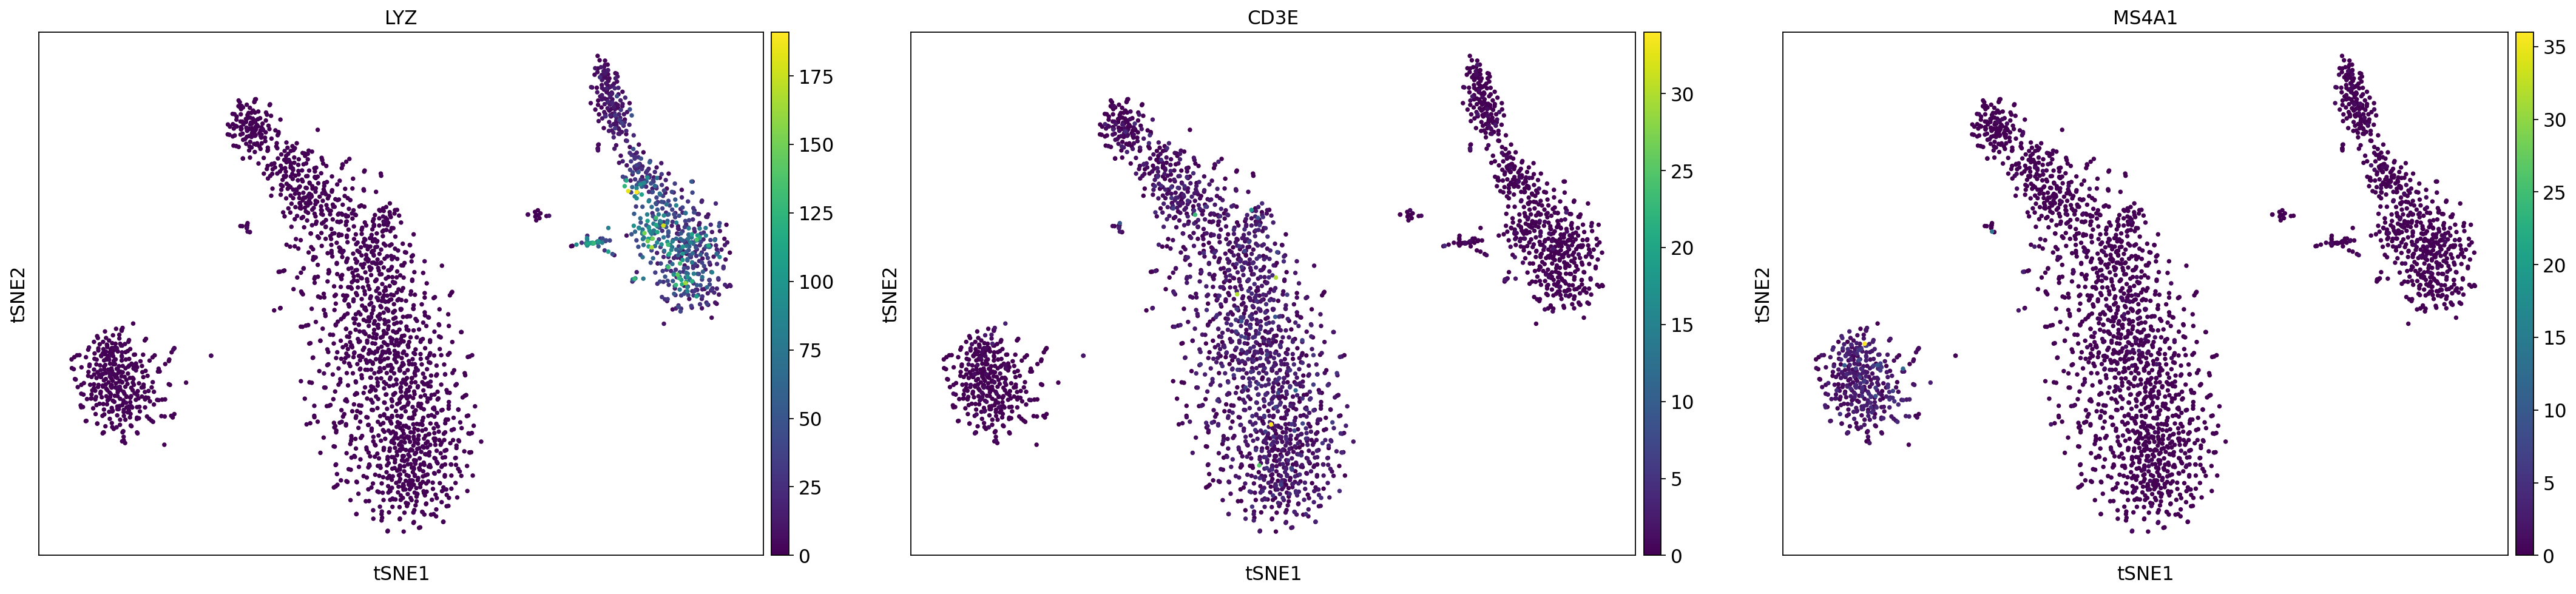

In [33]:
sc.pl.tsne(pbmc, color=['LYZ','CD3E','MS4A1'] )

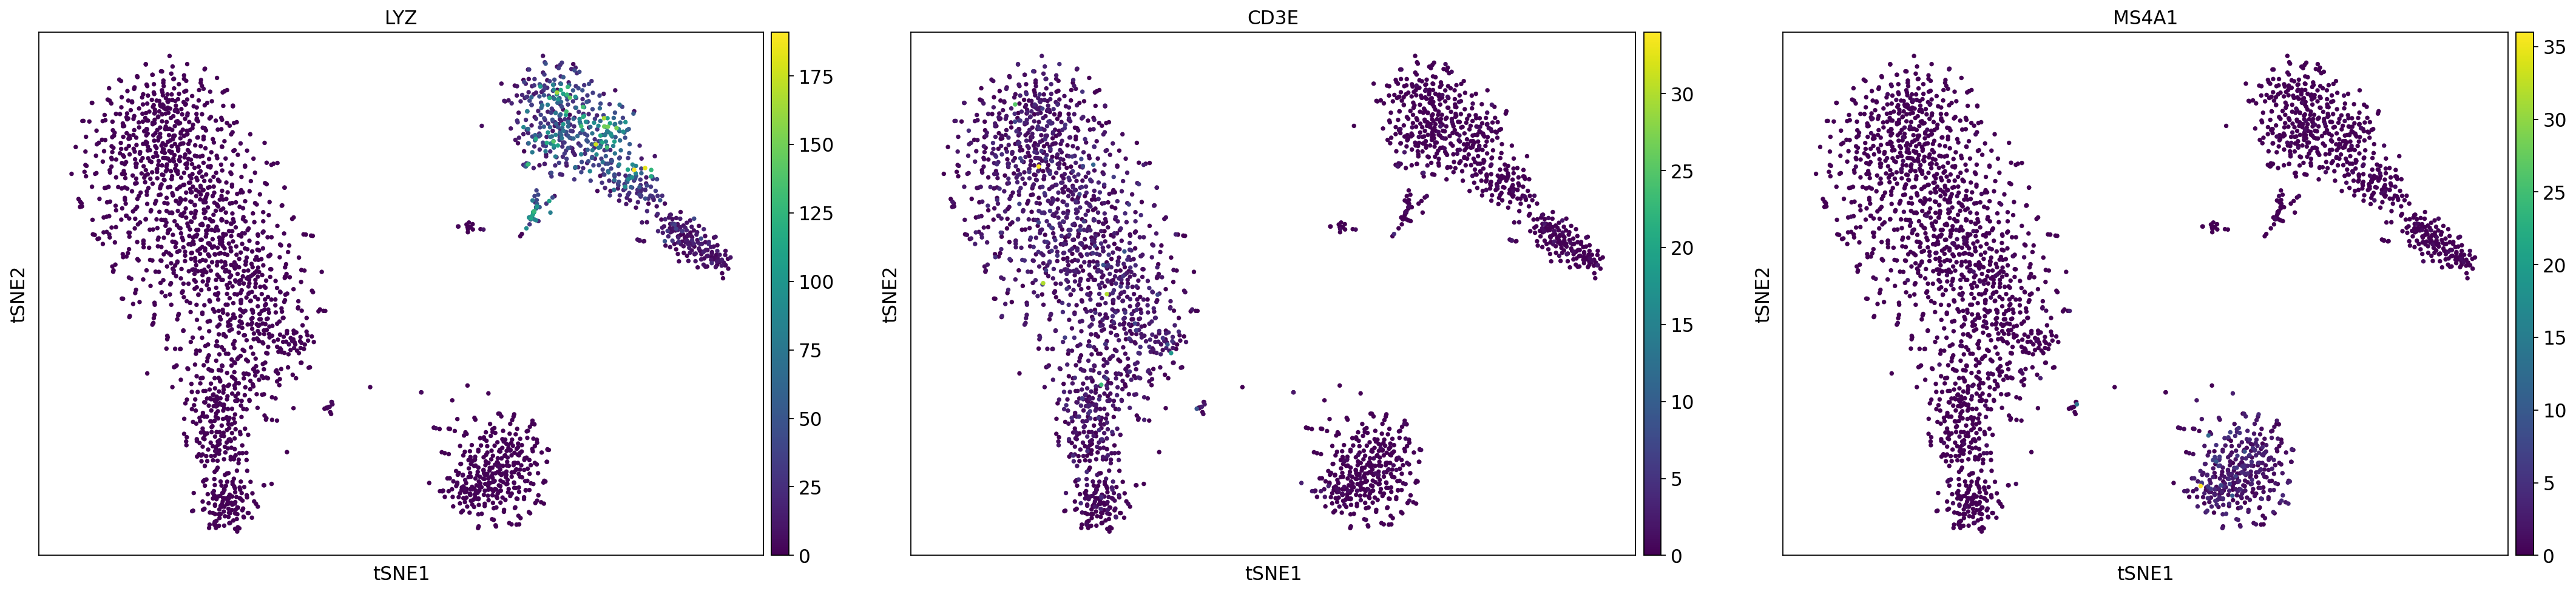

In [34]:
# what if we run tSNE again (for this example, the dataset is pretty small, so if you have time, you can run this - Note we set rando state (seed) to 2, you can try different numbers)
sc.tl.tsne(pbmc, random_state = 2)
sc.pl.tsne(pbmc, color=['LYZ','CD3E','MS4A1'] )

<font color='purple'> **Example**: why are the results from the two tSNE plots different? </font>

## 6 Clustering 

- Our dimensionality reduction methods show cells such that those which express similiar genes are closer together; while those which express genes differently are further apart. Since cells of the same type will typically express the same genes, it follows these 'clusters' of cells may represent biologically meaningful cell types. 

- In order to group our cells based on their gene expression, we can utilise different clustering strategies.
We will explore the most common of these below.

### 6.1 Kmeans clustering 

In [35]:
from sklearn.cluster import KMeans

data_pca = pbmc.obsm['X_pca']

In [36]:
kmeans_clust = KMeans(n_clusters = 3).fit(data_pca) 

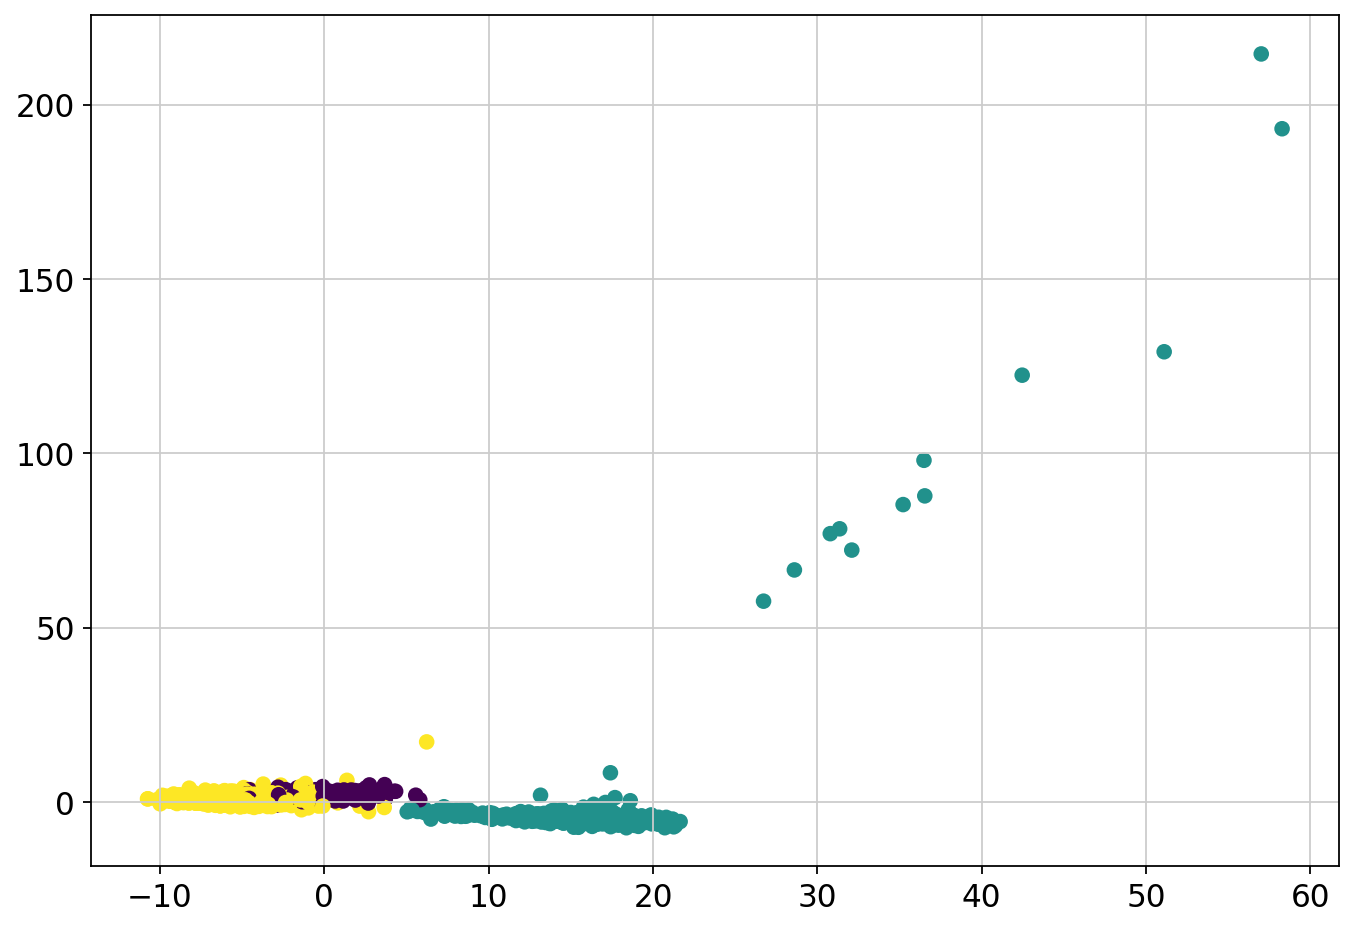

In [37]:
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=kmeans_clust.labels_)

In [38]:
# !pip install natsort 
from natsort import natsorted
cluster_results_kmeans = pd.Categorical(
        values=np.array(kmeans_clust.labels_).astype('U'),
        categories=natsorted(np.unique(np.array(kmeans_clust.labels_)).astype('U')),
    )

In [39]:
# Number of cells per cluster 
from collections import Counter
Counter(cluster_results_kmeans).values()

dict_values([1771, 695, 234])

In [40]:
pbmc.obs['kmeans'] = cluster_results_kmeans

In [42]:
# Optional install MulticoreTSNE for faster computation 
sc.tl.umap(pbmc)

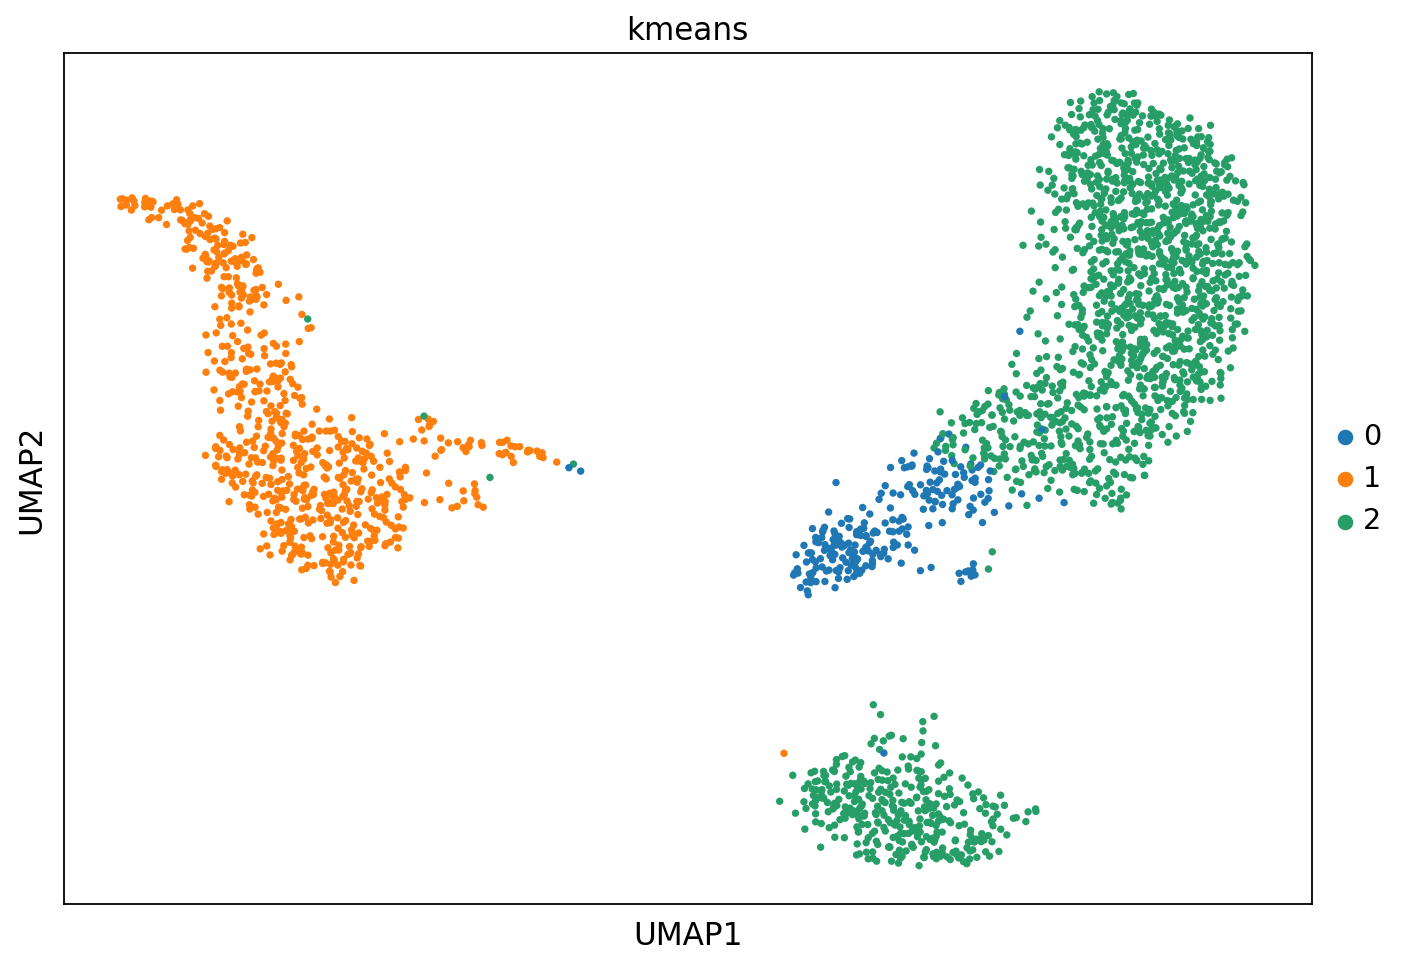

In [43]:
# UMAP visualisation 
sc.pl.umap(pbmc, color=['kmeans'])

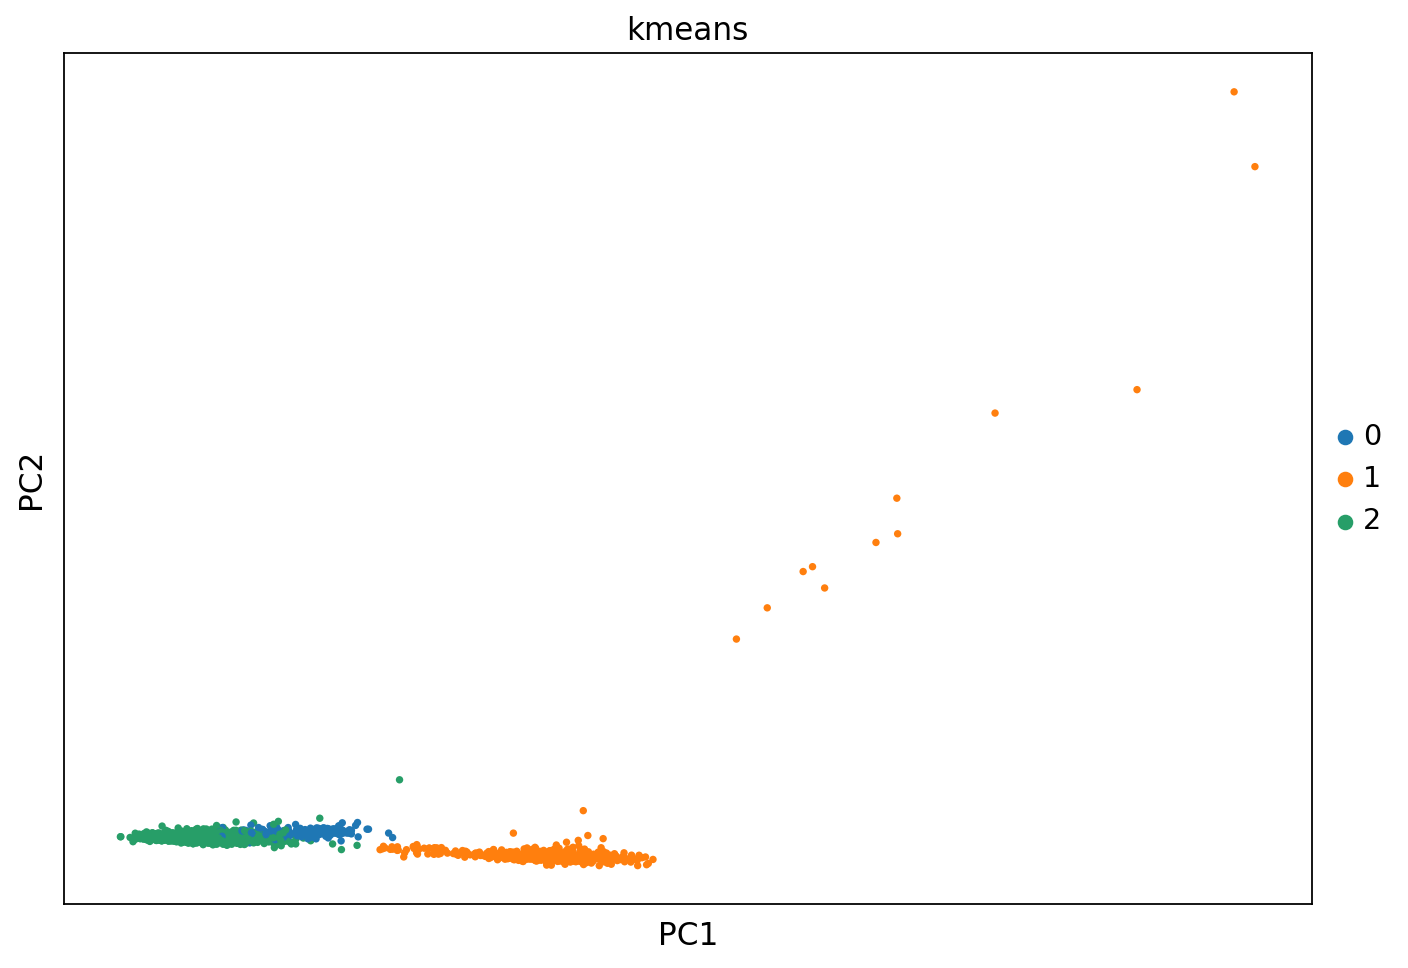

In [44]:
# PCA visualisation 
sc.pl.pca(pbmc, color=['kmeans'])

<font color='purple'> **Optional question - not assessed**: why can't the first two PCs separate cell clusters in a two-dimensional space? </font>

### 6.2 Hierarchical clustering 

In [45]:
from sklearn.cluster import AgglomerativeClustering
HC_clust = AgglomerativeClustering(n_clusters = 3, affinity='euclidean',linkage='ward').fit(data_pca)


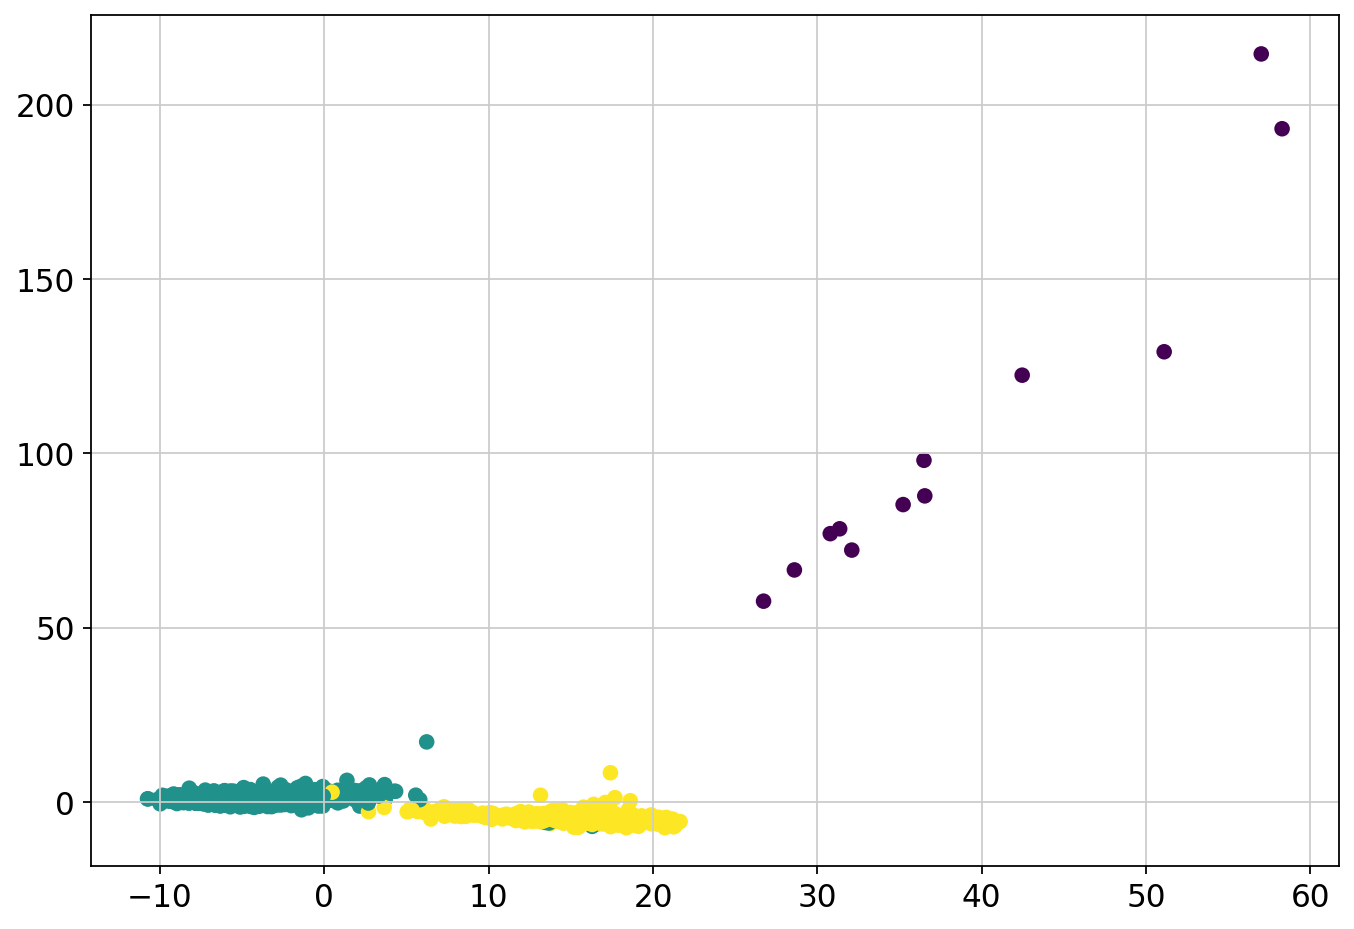

In [46]:
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=HC_clust.labels_)

In [47]:
cluster_results_HC = pd.Categorical(
        values=np.array(HC_clust.labels_).astype('U'),
        categories=natsorted(np.unique(np.array(HC_clust.labels_)).astype('U')),
    )

In [48]:
pbmc.obs['HCclust'] = cluster_results_HC

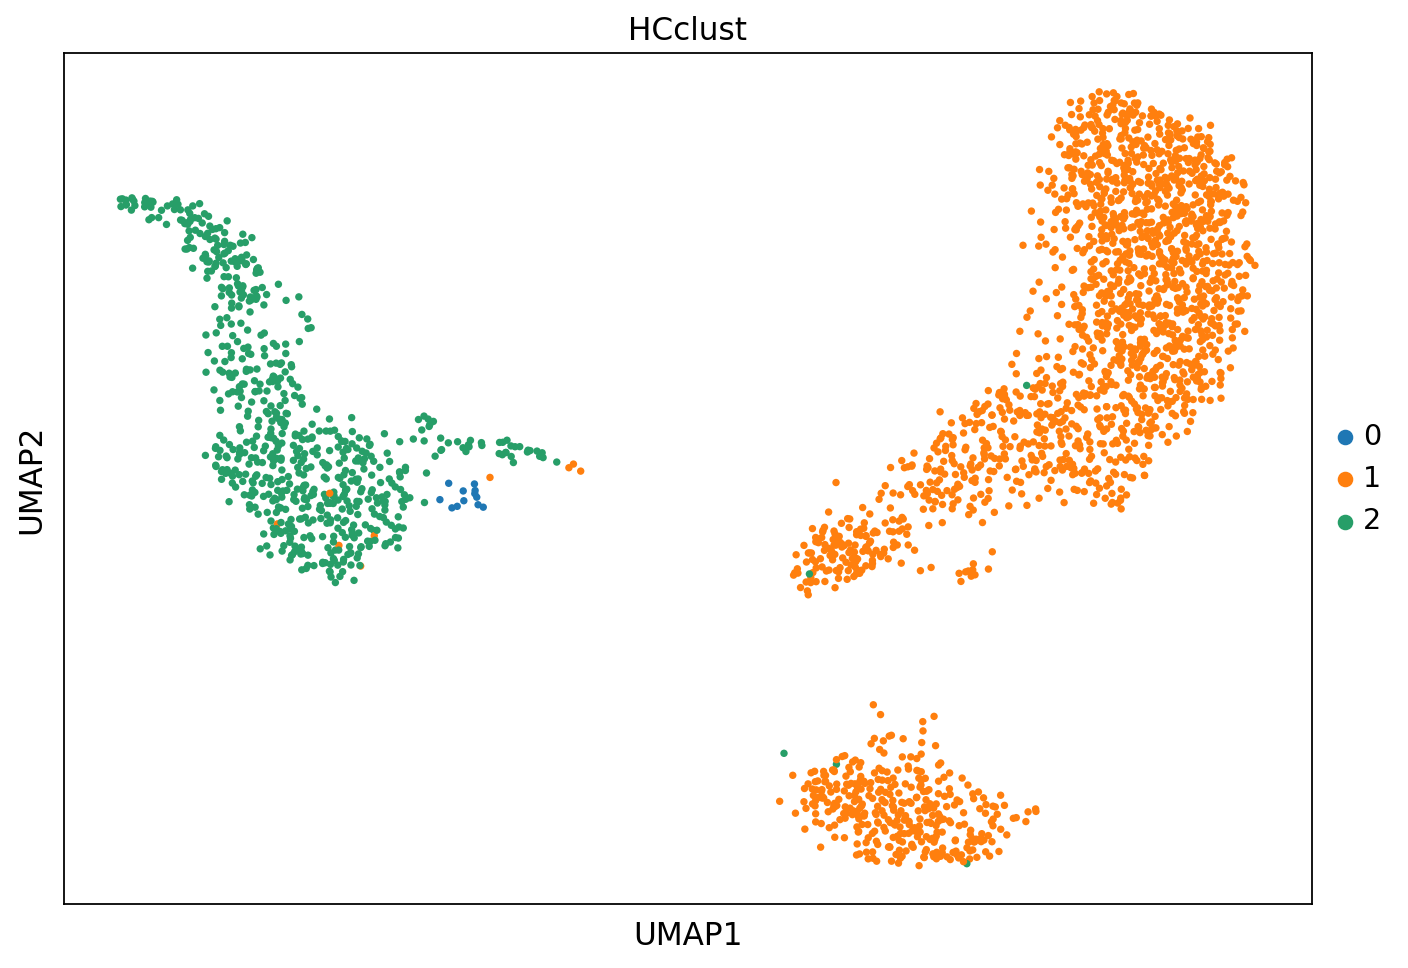

In [49]:
sc.pl.umap(pbmc, color=['HCclust'])

In [50]:
# function to draw the dendrogram tree.

from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

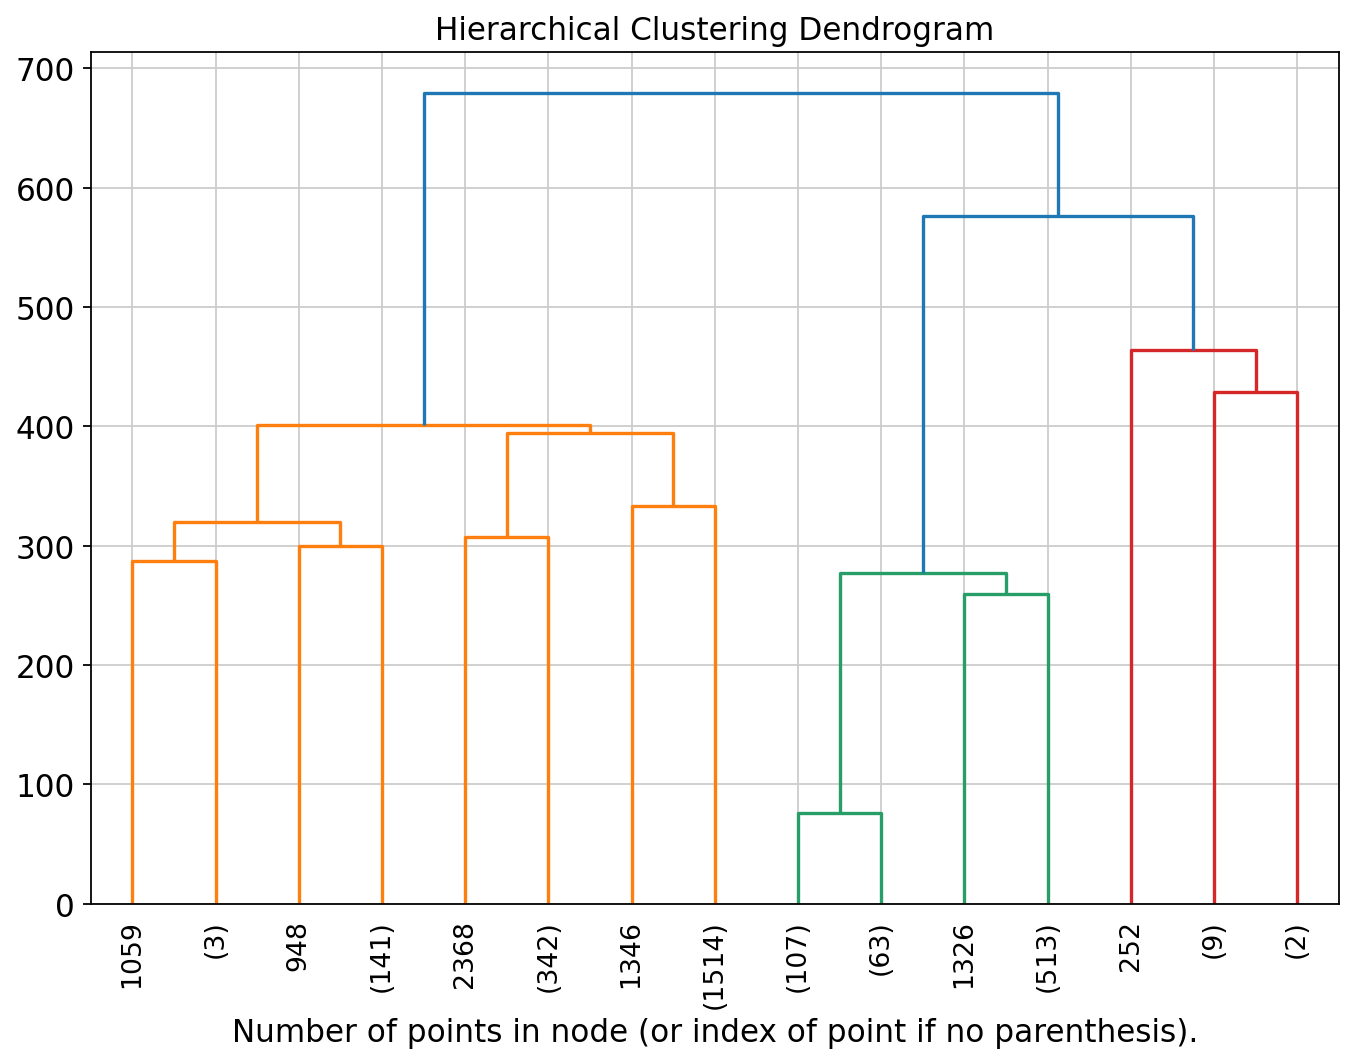

In [46]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(data_pca)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level',leaf_rotation =90,  p=3) #p: levels of the dendrogram tree are displayed, increase p will take much longer time 
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

<font color='purple'> **Example**: compare HC vs KMeans clustering results and explain key differences? </font>

### 6.3 Graph based clustering 

In [51]:
# Force-directed graph drawing of neighbourhood graph, preserving the topology of the data  
sc.tl.draw_graph(pbmc)

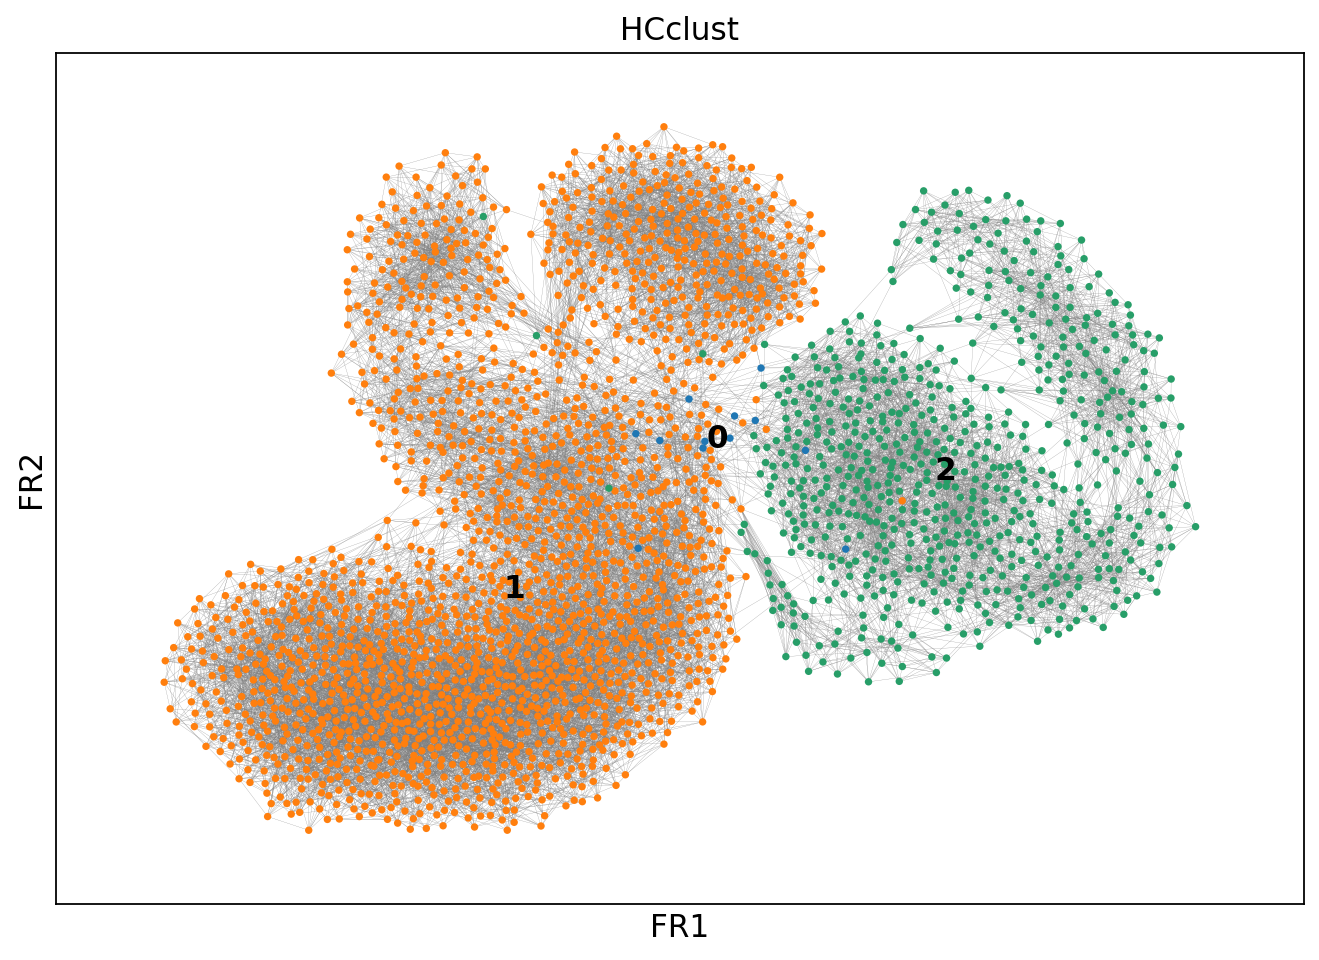

In [52]:
# graph connectivity between nodes, colored by previous HCclust  
sc.pl.draw_graph(pbmc, color=['HCclust'], legend_loc='on data', edges=True)

In [53]:
# graph-based clustering, using neibour connectivities 
sc.tl.leiden(pbmc, resolution =1) #Higher resolution values lead to more clusters.

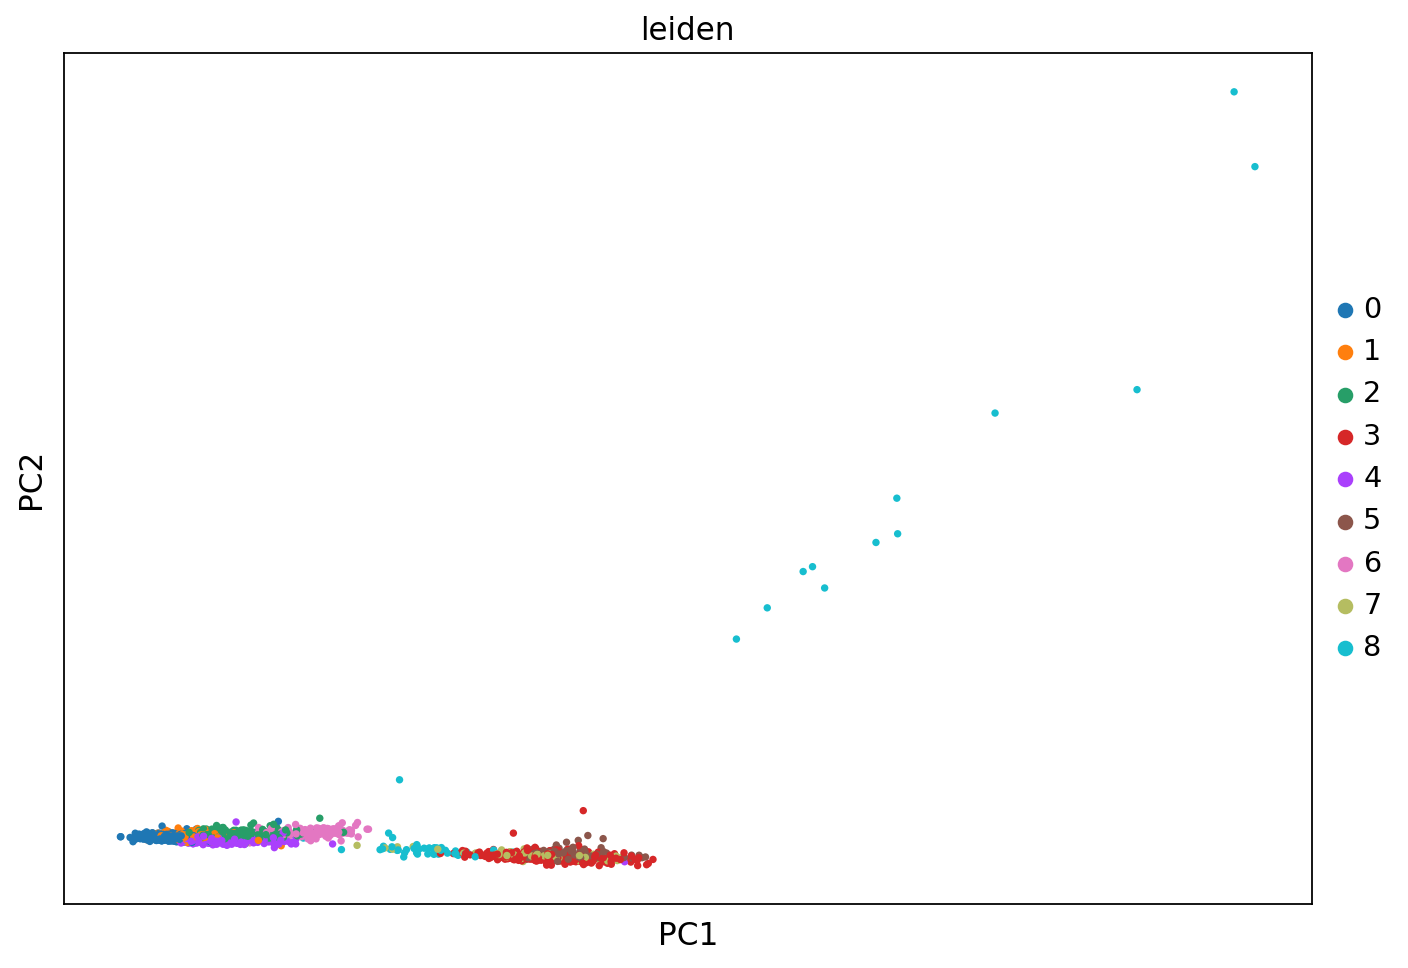

In [54]:
sc.pl.pca(pbmc, color=['leiden'])

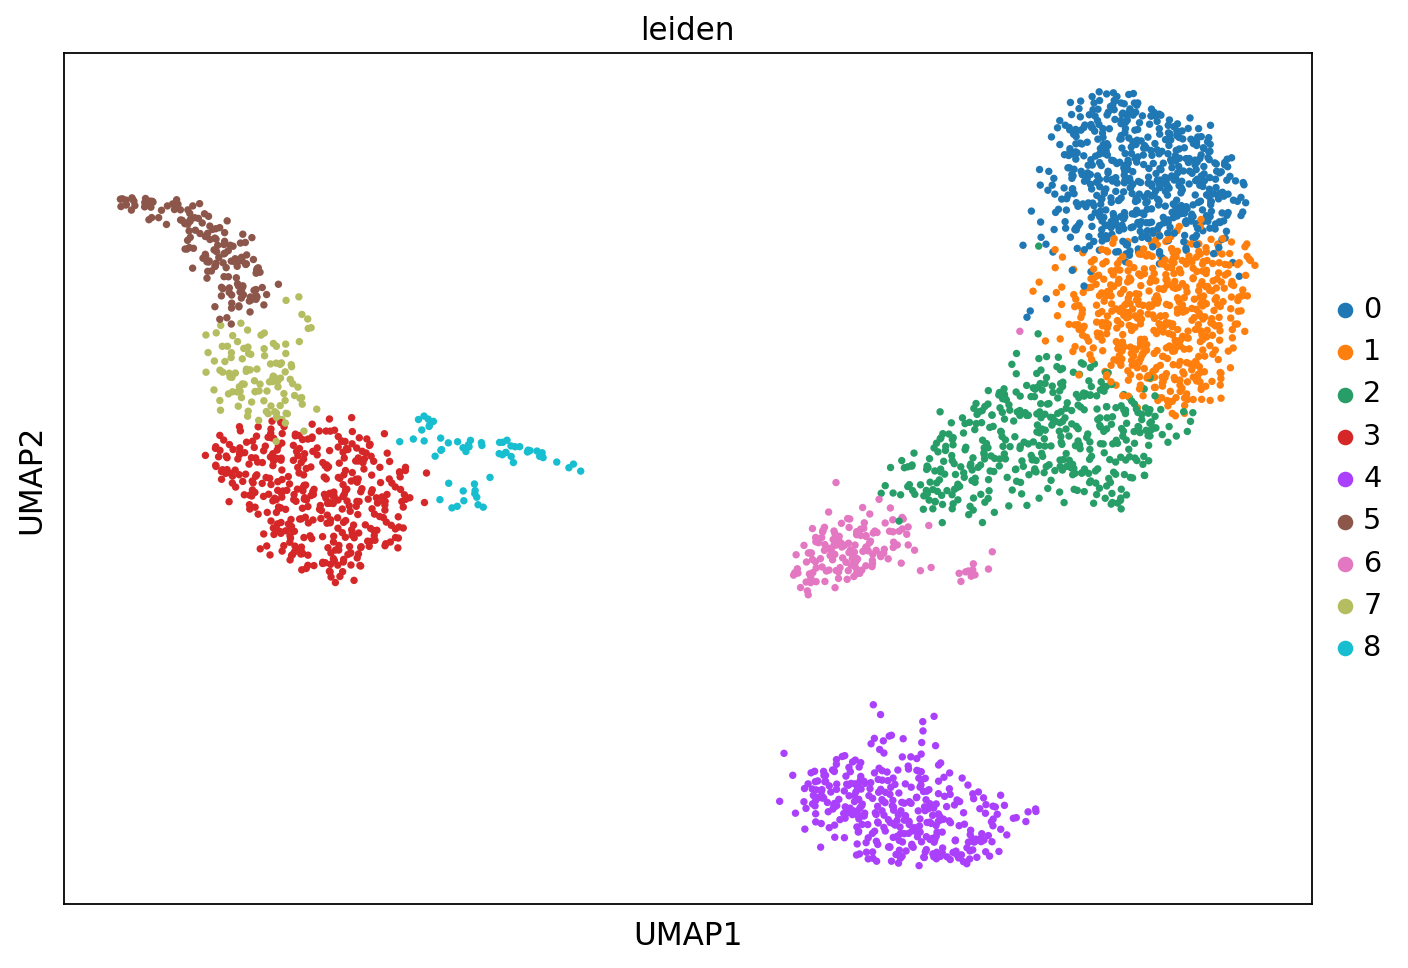

In [55]:
sc.pl.umap(pbmc, color=['leiden'])

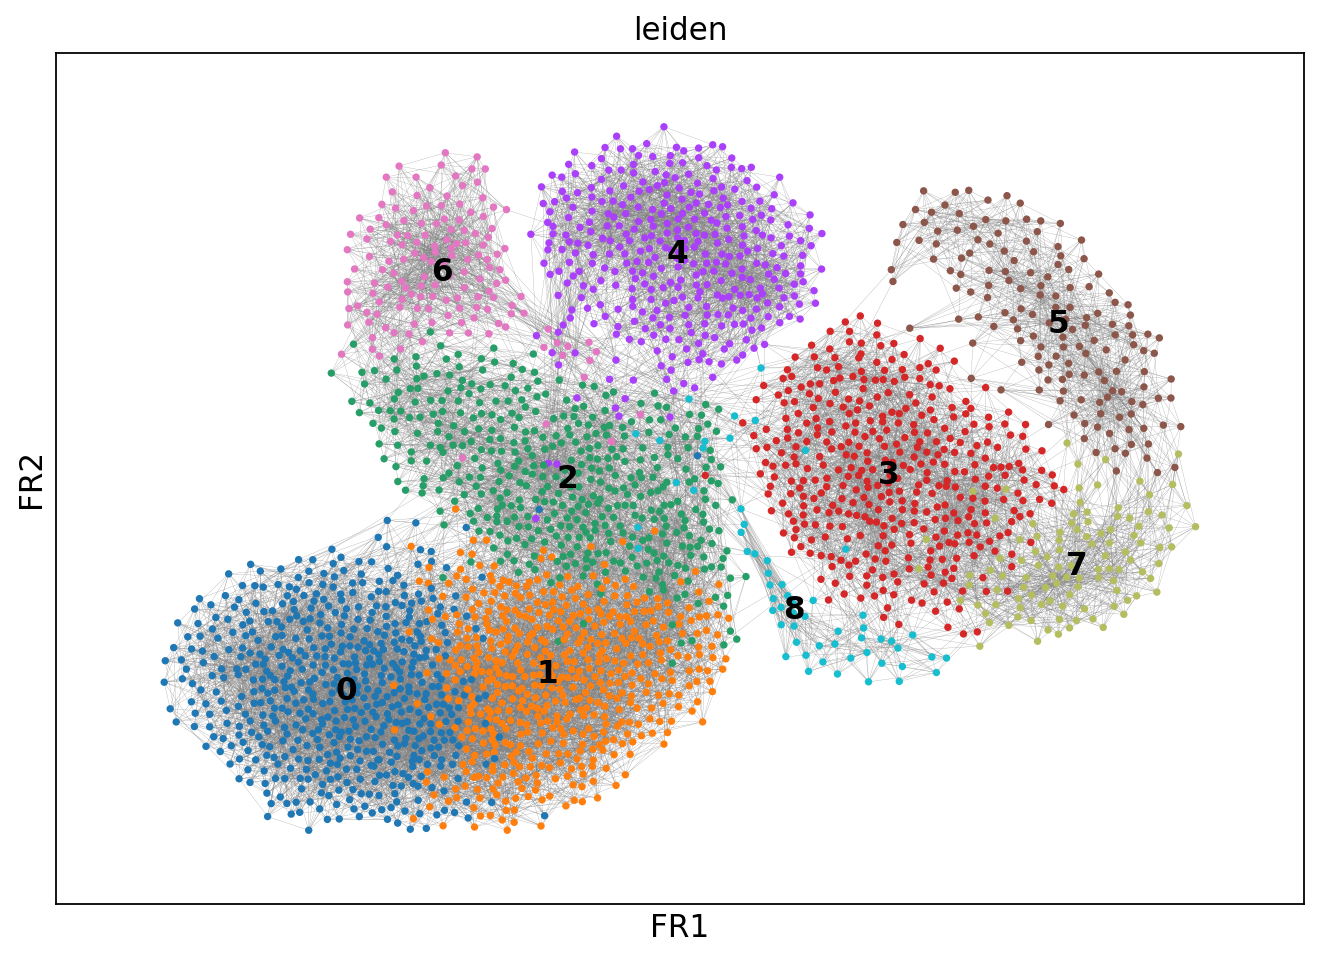

In [56]:
sc.pl.draw_graph(pbmc, color=['leiden'], legend_loc='on data', edges=True)

<font color='purple'> **Example**: For a fun excercise, rerun KMeans clustering with K=8 then  plots sc.pl.umap with KMeans labels and another plot with Leiden labels. Which plot separates clusters better? </font>

# Demuxplet sample pooling and demultiplexing (Please move to the R_Practical_Script)

## Refer to section: 7 Multiplexing single-cell experiments 
